In [1]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from joblib import dump



In [2]:
model = Word2Vec.load('word2vec.model')

def get_sentence_vector(sentence, model, num_words=100):
    words = sentence.split()
    vector = np.zeros(100)  
    nwords = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            nwords += 1
    if nwords:
        vector /= nwords  
    return vector


def file_to_vectors(file_path, model):
    with open(file_path, 'r', encoding='utf8') as file:
        sentences = file.readlines()
    return np.array([get_sentence_vector(sentence, model) for sentence in sentences])

vectorized_file1 = file_to_vectors('datasets//new_noxin.txt', model)
vectorized_file2 = file_to_vectors('datasets//new_yes.txt', model)


X = np.vstack((vectorized_file1, vectorized_file2))

y = np.array([0] * len(vectorized_file1) + [1] * len(vectorized_file2))

In [3]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

dump(svm, 'initial_svm_model.pkl')


['initial_svm_model.pkl']

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       215
           1       0.85      0.81      0.83       194

    accuracy                           0.85       409
   macro avg       0.85      0.84      0.85       409
weighted avg       0.85      0.85      0.85       409

auc: 0.9149364660752818


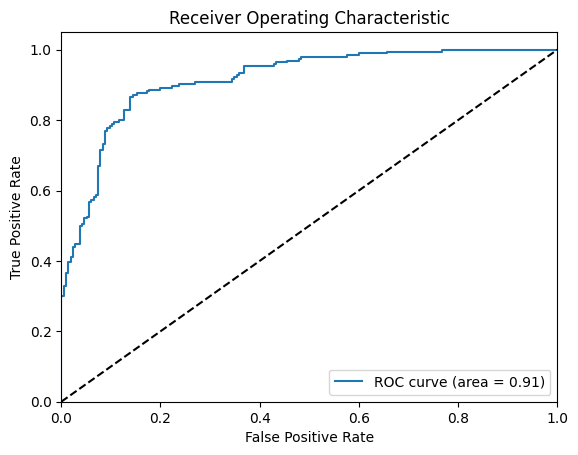

In [5]:
# 评估
predictions = svm.predict(X_test)
print(classification_report(y_test, predictions))
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



y_prob = svm.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("auc:",roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [6]:
from sklearn.model_selection import StratifiedKFold
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

cv = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=cv, scoring='accuracy')

grid_search.fit(X, y)

print("Best parameters found: ", grid_search.best_params_)

best_svm = grid_search.best_estimator_

import joblib
joblib.dump(best_svm, '10k_svm.pkl')

Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


['10k_svm.pkl']

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       215
           1       0.99      0.99      0.99       194

    accuracy                           0.99       409
   macro avg       0.99      0.99      0.99       409
weighted avg       0.99      0.99      0.99       409

auc: 0.9983696955166628


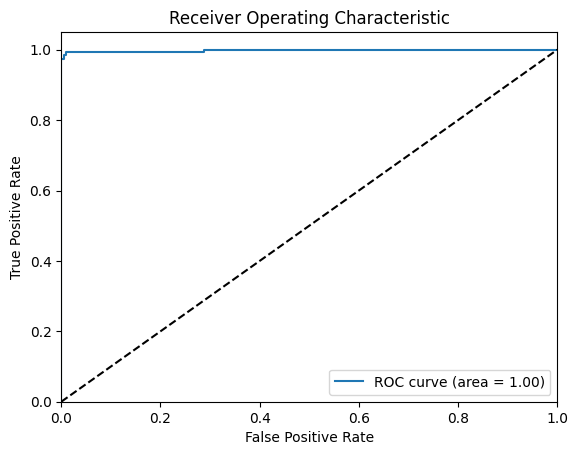

In [8]:
predictions = best_svm.predict(X_test)
print(classification_report(y_test, predictions))
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_svm.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("auc:",roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

c:\Users\qiao\miniconda3\envs\p2s\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\qiao\miniconda3\envs\p2s\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\qiao\miniconda3\envs\p2s\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\qiao\miniconda3\envs\p2s\lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "

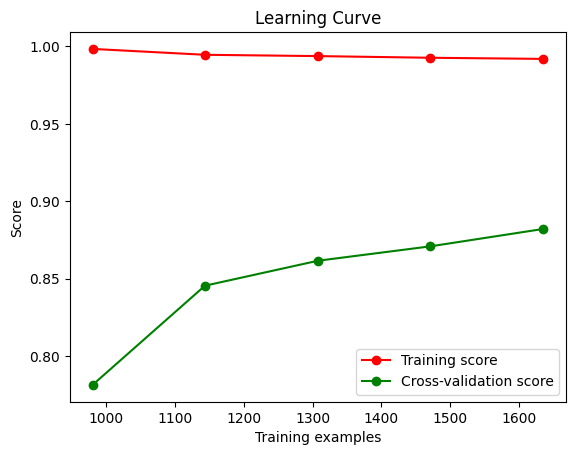

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 学习曲线
train_sizes, train_scores, val_scores = learning_curve(
    best_svm, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# 计算训练集和验证集的平均分数
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# 绘制学习曲线
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [13]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import joblib

# 模拟数据
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

cv = StratifiedKFold(n_splits=10)

svm = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=cv, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_svm1 = grid_search.best_estimator_

test_predictions = best_svm.predict(X_test)
print(classification_report(y_test, test_predictions))

joblib.dump(best_svm, 'best_svm1.pkl')

Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}


ValueError: X has 20 features, but SVC is expecting 100 features as input.

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       111
           1       0.87      0.85      0.86        89

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200

auc: 0.9160846239497924


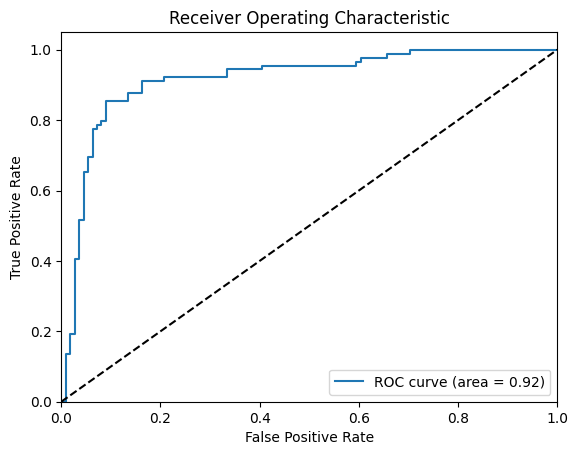

In [14]:
predictions = best_svm1.predict(X_test)
print(classification_report(y_test, predictions))
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = best_svm1.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("auc:",roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
joblib.dump(best_svm1, 'best_svm1.pkl')

['best_svm1.pkl']